# Aufgabe 14 : Labyrinthgenerator

Willkommen zu unserer Aufgabe der Woche!

Der Bundeswettbewerb Künstliche Intelligenz stellt euch jede Woche eine spannende oder kniffelige Programmieraufgabe, in der ihr euer Programmiergeschick auf die Probe stellen könnt.

Jede Woche habt ihr die Chance auf einen Amazon-Gutschein im Wert von 25€! Wer jede Aufgabe in einem Monat einschickt, nimmt in der Monatsverlosung teil und kann einen 50€-Amazon-Gutschein gewinnen! Ihr könnt eure Lösung immer bis Sonntag 22 Uhr der gleichen Woche per Mail an **aufgabe-der-woche@bw-ki.de** einreichen.

Bitte lade dazu das Notebook unter "File/Download as/Notebook (.ipynb)" runter. Verändere den Namen der Datei nicht und **vergiss nicht im ersten Feld deinen Namen und deine E-Mailadresse anzugeben**.

Es werden nur korrekte Lösungen berücksichtigt. Voraussetzung für die Teilnahme ist die Registrierung eures vollständigen Accounts im Loginbereich des Bundeswettbewerbs Künstliche Intelligenz. Es gelten die Teilnahmebedingungen (https://bw-ki.de/teilnahmebedingungen/) und Datenschutzrichtlinien (https://bw-ki.de/datenschutz/) des Wettbewerbs.

Wir freuen uns auch immer über **Feedback** von euch (siehe ganz unten)!

Dein vollständiger Name:

Deine E-Mailadresse:

## Links, rechts, geradeaus, du kommst hier nicht mehr raus, ...
aus Oomph! - Labyrinth

Diese Woche ist es die Aufgabe, einen Labyrinthgenerator zu schreiben. Aber zunächst zu unserer Motivation, bevor du dich noch im Labyrinth verlierst...

### Labyrinth als Graph
Ein Labyrinth kann auch als sogenannter Graph betrachtet werden. Graphen kann man wie Netze veranschaulichen; sie haben Kanten (Linien) und Knoten (Punkte). An Knoten können sich mehrere Kanten treffen. Wenn man die Pfade eines Labyrinths als Kanten versteht und die Kreuzungen und Kurven als Knoten, wird aus dem Labyrinth (in schwarz-weiß) ein Graph (in rot). Das folgende Bild veranschaulicht diese Idee:

<img src="http://caeze.bplaced.net/bwki/labyrinth1.png" alt="labyrinth_1" width="300"/>

An Graphen wird schon lange geforscht, daher gibt es eine Vielzahl an Verfahren und Algorithmen um verschiedenste Werte und Eigenschaften in einem Graphen zu bestimmen. Nächste Woche wollen wir uns einen der klassichen Graphen-Algorithmen anschauen, aber dazu benötigen wir Testgraphen, um die Implementierung zu validieren.

Daher ist die Aufgabe heute, einen Labyrinthgenerator zu entwickeln. Dazu sollst du Prim's Algorithmus implementieren. Wie dieser Algorithmus funktioniert, ist weiter unten in der Aufgabe beschrieben.

Zunächst geben wir eine Funktion vor, mit der sich Labyrinthe (als Liste von Listen, die Zellen enthalten) als Bild anzeigen lassen.

In [1]:
# importiere die nötigen Module, um Labyrinthe anzeigen zu können
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# mit dieser Funktion kannst du ein Labyrinth als Bild anzeigen
def zeige_labyrinth_an(feld, breite=10, höhe=10):
    labyrinth = np.zeros([len(feld), len(feld[0])])
    for y in range(len(feld)):
        for x in range(len(feld[y])):
            if labyrinth[x, y] == 0:
                zelle = feld[x][y]
                # die verschiedenen Typen von Zellen werden weiter
                # unten definiert
                if zelle.typ == 'p':
                    labyrinth[x, y] = 1.0
                if zelle.typ == 'w':
                    labyrinth[x, y] = 0.0
                if zelle.typ == 's':
                    labyrinth[x, y] = 1.0
                    labyrinth[x - 1, y] = 0.75
                if zelle.typ == 'z':
                    labyrinth[x, y] = 1.0
                    labyrinth[x + 1, y] = 0.75
    
    fig = plt.figure(figsize = (breite, höhe)) 
    ax = fig.add_subplot(111)
    ax.imshow(labyrinth, cmap='gray', clim=(0, 1))
    ax.axis('off')

Zudem geben wir eine Funktion vor, die ein Labyrinth-Feld generiert, bei dem alle Zwischenwände noch "zugemauert" sind. Durch geeignetes Entfernen dieser Zwischenwände können wir ein Labyrinth erzeugen. Das ist die Idee von Prim's Algorithmus.

Schau dir an wie die Datenstruktur für das Labyrinth implementiert ist.

Der Start unserer Labyrinthe ist immer am oberen und das Ziel am unteren Rand.

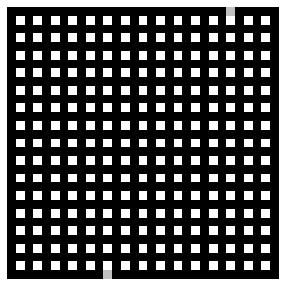

In [2]:
# importiere das Modul "random", da der Start und das Ziel im Labyrinth
# zufällig festgelegt werden sollen
import random

# um die Wände und Wege im Labyrinth darzustellen, verwenden wir Objekte
# der folgenden Klassen
class Wand():
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.typ = 'w'
    def __str__(self):
        return self.typ + ': ' + str(self.x) + '|' + str(self.y)

class Pfad():
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.ist_in_labyrinth = False
        self.typ = 'p'
    def __str__(self):
        return self.typ + ': ' + str(self.x) + '|' + str(self.y)

class Start():
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.ist_in_labyrinth = True
        self.typ = 's'
    def __str__(self):
        return self.typ + ': ' + str(self.x) + '|' + str(self.y)

class Ziel():
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.ist_in_labyrinth = False
        self.typ = 'z'
    def __str__(self):
        return self.typ + ': ' + str(self.x) + '|' + str(self.y)

# In dieser Funktion wird ein Labyrinth-Feld erzeugt, das einen zufälligen
# Startpunkt und ein zufälliges Ziel hat. Der Start ist immer am oberen
# und das Ziel am unteren Rand.
# Dieses Labyrinth-Feld hat noch keine Wege, da diese erst vom Algorithmus
# hinzugefügt werden sollen.
def erstelle_feld(größe):
    # zu kleine Labyrinthe sind nicht zulässig
    größe = max(5, größe)
    
    # ein Labyrinth muss immer eine ungerade Anzahl an Wegen und Wänden haben,
    # da es rundum umrandet ist
    if größe % 2 == 0:
        größe += 1
    
    höhe = größe
    breite = größe
    
    # erzeuge das Labyrinth-Feld, gebe auch das Start- und Zielfeld zurück
    feld = []
    for y in range(höhe):
        zeile = []
        for x in range(breite):
            if x % 2 == 0 or y % 2 == 0:
                zeile.append(Wand(x, y))
            else:
                zeile.append(Pfad(x, y))
        feld.append(zeile)
    
    # setze den Start und das Ziel zufällig fest
    start_index = random.randint(0, (breite - 3) / 2) * 2 + 1
    ziel_index = random.randint(0, (breite - 3) / 2) * 2 + 1
    start = Start(start_index, 1)
    ziel = Ziel(ziel_index, höhe - 2)
    feld[1][start_index] = start
    feld[höhe - 2][ziel_index] = ziel
    return feld, start, ziel

# erstelle testweise ein Labyrinth und zeige es an
feld, start, ziel = erstelle_feld(30)
zeige_labyrinth_an(feld, 5, 5)

### Prim's Algorithmus

Der folgende Pseudocode ist dieser Wikipedia-Seite entnommen (übersetzt und etwas angepasst):

https://en.wikipedia.org/wiki/Maze_generation_algorithm#Randomized_Prim's_algorithm

Hier kannst du dir auch eine Animation anschauen, wie der Algorithmus arbeitet;

https://upload.wikimedia.org/wikipedia/commons/b/b1/MAZE_30x20_Prim.ogv

Der Algorithmus funktioniert folgendermaßen:

<code>1. erzeuge das Labyrinth-Feld, auf dem alle Zwischenwände noch zugemauert sind</code>  
<code>2. finde die Zwischenwände der Start-Zelle und schreibe diese in die Liste der Zwischenwände</code>  
<code>3. WHILE die Liste der Zwischenwände ist nicht leer:</code>  
<code>    3.1 wähle eine zufällige Zwischenwand aus der Liste der Zwischenwände.</code>  
<code>    3.2 WENN nur eine der beiden Nachbar-Pfad-Zellen dieser Zwischenwand Teil des Labyrinths ist:</code>  
<code>        3.2.1 entferne die Zwischenwand</code>  
<code>        3.2.2 markiere die dadurch neu verbundene Zelle als Teil des Labyrinths</code>  
<code>        3.2.3 füge die anderen Zwischenwände der neu verbundenen Zelle zur Liste der Zwischenwände hinzu</code>  
<code>    3.3 entferne die zufällige Zwischenwand aus der Liste der Zwischenwände.</code>

Diesen Pseudocode sollst du im nächsten Codeblock implementieren.

Von Prim's Algorithmus werden Labyrinthe zufällig generiert. Dein Labyrinth sollte in etwa so aussehen (Darstellung verkleinert):

<img src="http://caeze.bplaced.net/bwki/labyrinth2.png" alt="labyrinth_2" width="300"/>

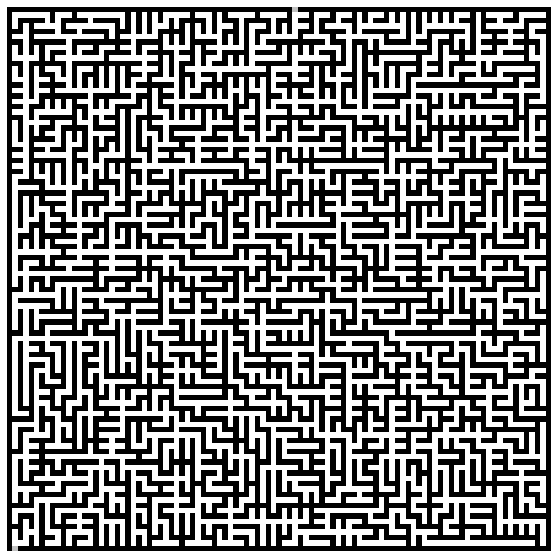

In [3]:
# Diese Funktion sucht im Feld nach der Zelle an Position (x, y) und gibt diese zurück.
# Wenn die Zelle nicht gefunden wurde, weil (x, y) außerhalb des Felds ist, wird "None"
# zurückgegeben.
def finde_zelle(feld, x, y):
    return ...

# Diese Funktion gibt alle Wände (schwarz) zurück, die zu der Zelle "pfad_zelle" gehören.
# Die Zelle "pfad_zelle" muss ein Pfad sein (weiß)!
def finde_wände_des_pfads(feld, pfad_zelle):
    x = pfad_zelle.x
    y = pfad_zelle.y
    return ...

# Diese Funktion gibt die zwei Pfad-Zellen (weiß) auf den beiden Seiten einer Zwischenwand (schwarz) zurück.
# Eine Zwischenwand-Zelle hat immer nur maximal zwei Pfad-Zellen als Nachbarn!
def finde_pfade_der_wand(feld, wand_zelle):
    x = wand_zelle.x
    y = wand_zelle.y
    return ...

# In dieser Funktion wird das Labyrinth erstellt.
# Dazu sollst du Prim's Algorithmus implementieren.
def prims_algorithmus(größe):
    feld, start, ziel = erstelle_feld(größe)
    wände = finde_wände_des_pfads(feld, start)
    while len(wände) != 0:
        ...
    return feld

labyrinth = prims_algorithmus(100)
zeige_labyrinth_an(labyrinth)

Wunderbar! Nun haben wir endlos viele Testmöglichkeiten für die Aufgabe der nächsten Woche. In dieser Aufgabe werden wir Graphen aus den Labyrinthen machen und dann den Weg vom Start zum Ziel suchen.

## Feedback für uns (freiwillig)
War diese Aufgabe zu leicht, zu schwer oder genau richtig?

Wie lang hast du für diese Aufgabe ungefähr gebraucht?

Welche Art von Aufgaben wünschst du dir in Zukunft?